## Лабораторная работа №4. Оценка качества моделей машинного обучения.
### Часть 2. Задача многоклассовой классификации.

Используемый набор данных: [Wine](https://archive.ics.uci.edu/ml/datasets/Wine)

In [1]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from itertools import cycle
import os
import requests

%matplotlib inline

pd.options.display.max_columns = None

In [2]:
def downloadFile(url, filePath):
    if not os.path.exists(filePath):
        req = requests.get(url)
        f = open(filePath, "wb")
        f.write(req.content)
        f.close

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine"
downloadFile(url + "/wine.data", "dataset/wine.data")
downloadFile(url + "/wine.names", "dataset/wine.names")

In [3]:
headers = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
           "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]  
data = pd.read_csv("dataset/wine.data", names=headers)
data["Class"] = data["Class"].astype("category")
data.sample(40)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
86,2,12.16,1.61,2.31,22.8,90,1.78,1.69,0.43,1.56,2.450000,1.330,2.26,495
56,1,14.22,1.70,2.30,16.3,118,3.20,3.00,0.26,2.03,6.380000,0.940,3.31,970
16,1,14.30,1.92,2.72,20.0,120,2.80,3.14,0.33,1.97,6.200000,1.070,2.65,1280
109,2,11.61,1.35,2.70,20.0,94,2.74,2.92,0.29,2.49,2.650000,0.960,3.26,680
46,1,14.38,3.59,2.28,16.0,102,3.25,3.17,0.27,2.19,4.900000,1.040,3.44,1065
70,2,12.29,1.61,2.21,20.4,103,1.10,1.02,0.37,1.46,3.050000,0.906,1.82,870
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.300000,0.600,1.62,840
168,3,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.660000,0.740,1.80,750
110,2,11.46,3.74,1.82,19.5,107,3.18,2.58,0.24,3.58,2.900000,0.750,2.81,562
124,2,11.87,4.31,2.39,21.0,82,2.86,3.03,0.21,2.91,2.800000,0.750,3.64,380


In [4]:
data.isna().sum()

Class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

Пропусков в данных нет.

Подготовим данные для классификации: выберем признаки и метки и сформируем тренировочные и тестовые наборы.

In [5]:
classes = data["Class"].unique()
n_classes = len(classes)
y = label_binarize(data["Class"], classes=classes)
X = data.drop(columns=["Class"]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=25)

Создадим классификатор, обучим его, а затем выполним классификацию. Для этой задачи используем подход [One-Vs-All](https://ru.coursera.org/lecture/supervised-learning/mnoghoklassovaia-klassifikatsiia-21cCQ), также известный как [One-Vs-The-Rest](https://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest)

In [6]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=159))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

Для каждого класса вычислим ROC-кривую и значение показателя AUC.

In [7]:
fpr, tpr, auc = dict(), dict(), dict()
for i in range(n_classes):
    y_test_cl = y_test[:,i]
    y_score_cl = y_score[:,i]
    fpr[i], tpr[i], _ = roc_curve(y_test_cl, y_score_cl)
    auc[i] = roc_auc_score(y_test_cl, y_score_cl)

Построим ROC-кривые.

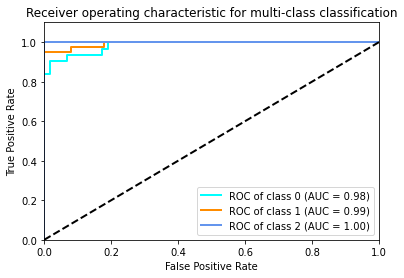

In [8]:
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC of class {0} (AUC = {1:0.2f})'.format(i, auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class classification')
plt.legend(loc="lower right")
plt.show()

Высокие значения AUC говорят о качественной классификации.

Построим таблицы сопряженности.

In [ ]:
cols = list(data.columns)
used = dict()
cnt = 0
for i in cols:
    for j in cols:
        if i == j or used.get((j,i)) == True: continue
        print(f"\n\tТаблица сопряженности для атрибутов '{i}' и '{j}'")
        display(pd.DataFrame(pd.crosstab(data[i], data[j])))
        used[(i,j)] = True


	Таблица сопряженности для атрибутов 'Class' и 'Alcohol'


Alcohol,11.03,11.41,11.45,11.46,11.56,11.61,11.62,11.64,11.65,11.66,11.76,11.79,11.81,11.82,11.84,11.87,11.96,12.00,12.04,12.07,12.08,12.16,12.17,12.20,12.21,12.22,12.25,12.29,12.33,12.34,12.36,12.37,12.42,12.43,12.45,12.47,12.51,12.52,12.53,12.58,12.60,12.64,12.67,12.69,12.70,12.72,12.77,12.79,12.81,12.82,12.84,12.85,12.86,12.87,12.88,12.93,12.96,12.99,13.03,13.05,13.07,13.08,13.11,13.16,13.17,13.20,13.23,13.24,13.27,13.28,13.29,13.30,13.32,13.34,13.36,13.39,13.40,13.41,13.45,13.48,13.49,13.50,13.51,13.52,13.56,13.58,13.62,13.63,13.64,13.67,13.68,13.69,13.71,13.72,13.73,13.74,13.75,13.76,13.77,13.78,13.82,13.83,13.84,13.86,13.87,13.88,13.90,13.94,14.02,14.06,14.10,14.12,14.13,14.16,14.19,14.20,14.21,14.22,14.23,14.30,14.34,14.37,14.38,14.39,14.75,14.83
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,4,1,0,0,1,0,1,0,2,0,1,1,1,0,0,0,1,0,1,0,1,0,1,1,0,2,1,0,1,1,0,1,0,1,1,1,1,1,1,1,0,1,2,0,1,1,1,1,1,1,2,2,1,0,0,1,1,1,2,1,1,0,1,2,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,1,1,3,1,1,5,1,1,0,1,1,1,4,2,1,0,6,3,1,0,1,1,1,0,0,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,0,0,1,0,1,0,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,2,0,1,0,1,0,0,0,1,0,1,0,2,0,1,1,1,1,0,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Malic acid'


Malic acid,0.74,0.89,0.90,0.92,0.94,0.98,0.99,1.01,1.07,1.09,1.10,1.13,1.17,1.19,1.21,1.24,1.25,1.29,1.33,1.34,1.35,1.36,1.39,1.41,1.43,1.45,1.47,1.48,1.50,1.51,1.52,1.53,1.57,1.59,1.60,1.61,1.63,1.64,1.65,1.66,1.67,1.68,1.70,1.71,1.72,1.73,1.75,1.76,1.77,1.78,1.80,1.81,1.83,1.86,1.87,1.88,1.89,1.90,1.92,1.95,1.97,1.99,2.02,2.05,2.06,2.08,2.12,2.13,2.15,2.16,2.31,2.36,2.39,2.40,2.43,2.45,2.46,2.51,2.55,2.56,2.58,2.59,2.67,2.68,2.76,2.81,2.83,2.89,2.96,2.99,3.03,3.10,3.12,3.17,3.24,3.26,3.27,3.30,3.37,3.43,3.45,3.55,3.57,3.59,3.70,3.74,3.80,3.83,3.84,3.86,3.87,3.88,3.90,3.91,3.98,3.99,4.04,4.10,4.12,4.28,4.30,4.31,4.36,4.43,4.60,4.61,4.72,4.95,5.04,5.19,5.51,5.65,5.80
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,2,0,0,1,1,1,1,0,1,2,2,1,1,2,1,2,1,5,1,1,2,1,1,3,1,1,2,0,1,2,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,0,3,1,2,0,0,0,3,1,0,0,1,2,0,0,0,1,2,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,1,1,1,0,1,1,0,0,1,1,2,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,0



	Таблица сопряженности для атрибутов 'Class' и 'Ash'


Ash,1.36,1.70,1.71,1.75,1.82,1.88,1.90,1.92,1.94,1.95,1.98,1.99,2.00,2.02,2.04,2.10,2.12,2.13,2.14,2.15,2.16,2.17,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.48,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.58,2.59,2.60,2.61,2.62,2.64,2.65,2.67,2.68,2.69,2.70,2.72,2.73,2.74,2.75,2.78,2.80,2.84,2.86,2.87,2.92,3.22,3.23
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,0,2,0,0,1,0,0,1,0,0,0,1,0,2,2,1,2,1,1,0,3,0,1,1,1,2,1,1,1,2,1,1,2,1,1,0,0,1,1,0,1,1,2,2,0,2,1,2,0,3,1,0,0,0,0,1,1,0,1,0,1,0
2,1,2,1,1,1,1,1,3,1,1,3,1,2,1,0,1,1,1,0,0,1,2,1,3,2,1,1,2,0,1,1,3,1,3,1,2,0,1,0,1,1,1,0,2,0,0,0,2,0,2,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,2,0,0,1,0,1,2,0,2,0,2,0,3,3,2,1,3,0,2,0,0,0,0,1,0,4,0,0,0,0,2,0,0,1,0,1,1,1,3,0,0,0,1,2,1,0,1,1,0,0,0,1,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Alcalinity of ash'


Alcalinity of ash,10.6,11.2,11.4,12.0,12.4,13.2,14.0,14.6,14.8,15.0,15.2,15.5,15.6,16.0,16.1,16.2,16.3,16.4,16.5,16.6,16.7,16.8,17.0,17.1,17.2,17.4,17.5,17.6,17.8,18.0,18.1,18.5,18.6,18.8,18.9,19.0,19.1,19.4,19.5,19.6,20.0,20.4,20.5,20.7,20.8,21.0,21.5,21.6,22.0,22.5,22.8,23.0,23.5,23.6,24.0,24.5,25.0,25.5,26.0,26.5,27.0,28.5,30.0
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,1,2,1,0,1,2,2,1,6,1,1,1,1,1,1,1,3,2,1,3,1,1,1,1,2,0,0,2,2,1,1,1,1,1,0,3,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,1,0,0,0,5,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,7,1,3,0,1,0,7,0,0,2,1,3,1,1,1,1,6,4,1,3,4,1,1,0,1,2,1,1,0,1,1,0,2,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,4,0,0,0,1,0,0,4,0,9,0,1,0,0,4,4,0,4,2,0,2,1,0,3,2,3,1,0,0,1,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Magnesium'


Magnesium,70,78,80,81,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,112,113,115,116,117,118,119,120,121,122,123,124,126,127,128,132,134,136,139,151,162
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,3,1,3,0,2,5,4,2,1,1,1,2,3,2,2,2,1,2,2,1,3,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0
2,1,3,4,1,1,3,5,9,3,9,0,2,0,2,0,3,0,1,2,3,1,1,3,1,2,1,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1
3,0,0,1,0,0,0,1,2,0,4,4,1,1,2,1,1,1,4,2,3,0,0,1,2,1,1,1,3,1,0,0,1,3,1,0,1,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Total phenols'


Total phenols,0.98,1.10,1.15,1.25,1.28,1.30,1.35,1.38,1.39,1.40,1.41,1.45,1.48,1.50,1.51,1.54,1.55,1.59,1.60,1.61,1.62,1.63,1.65,1.68,1.70,1.72,1.74,1.75,1.78,1.79,1.80,1.83,1.85,1.88,1.89,1.90,1.92,1.93,1.95,1.98,2.00,2.02,2.05,2.10,2.11,2.13,2.20,2.22,2.23,2.30,2.32,2.35,2.36,2.40,2.41,2.42,2.45,2.46,2.48,2.50,2.53,2.55,2.56,2.60,2.61,2.62,2.63,2.64,2.65,2.70,2.72,2.74,2.75,2.80,2.83,2.85,2.86,2.88,2.90,2.95,2.96,2.98,3.00,3.02,3.10,3.15,3.18,3.20,3.25,3.27,3.30,3.38,3.40,3.50,3.52,3.85,3.88
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,1,1,3,0,1,1,1,0,0,4,1,0,1,1,2,2,1,0,1,5,0,3,1,1,0,4,1,1,6,0,2,1,0,1,2,1,2,0,1,0,0,1,1
2,0,1,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,2,1,0,1,2,1,0,1,0,1,1,0,0,0,1,1,1,1,1,0,2,2,3,1,1,2,1,1,6,1,1,0,0,0,1,0,0,2,1,1,1,2,1,2,2,1,0,1,0,0,0,0,0,2,0,0,1,1,1,0,1,1,0,1,0,1,0,0,2,0,0,0,1,1,0,1,1,0,0
3,1,0,1,1,1,1,1,2,2,2,1,0,3,1,1,1,2,1,0,0,2,0,2,2,3,0,1,0,0,1,3,1,0,0,0,1,0,1,0,1,2,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Flavanoids'


Flavanoids,0.34,0.47,0.48,0.49,0.50,0.51,0.52,0.55,0.56,0.57,0.58,0.60,0.61,0.63,0.65,0.66,0.68,0.69,0.70,0.75,0.76,0.78,0.80,0.83,0.84,0.92,0.96,0.99,1.02,1.09,1.10,1.20,1.22,1.25,1.28,1.30,1.31,1.32,1.36,1.39,1.41,1.46,1.50,1.57,1.58,1.59,1.60,1.61,1.64,1.69,1.75,1.76,1.79,1.84,1.85,1.92,1.94,2.00,2.01,2.03,2.04,2.09,2.11,2.13,2.14,2.17,2.19,2.21,2.24,2.25,2.26,2.27,2.29,2.33,2.37,2.41,2.43,2.45,2.50,2.51,2.52,2.53,2.55,2.58,2.61,2.63,2.64,2.65,2.68,2.69,2.74,2.76,2.78,2.79,2.86,2.88,2.89,2.90,2.91,2.92,2.94,2.97,2.98,2.99,3.00,3.03,3.04,3.06,3.10,3.14,3.15,3.17,3.18,3.19,3.23,3.24,3.25,3.27,3.29,3.32,3.39,3.40,3.49,3.54,3.56,3.64,3.67,3.69,3.74,3.75,3.93,5.08
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,2,0,0,1,1,1,0,0,1,1,1,1,3,2,1,2,1,1,0,1,0,1,1,1,1,1,2,1,2,1,1,1,0,1,1,2,0,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,2,1,1,0,1,1,0,1,1,1,1,1,2,1,1,2,2,2,1,1,2,1,1,1,1,1,3,1,1,1,1,1,2,0,1,1,1,2,2,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,3,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,2,1,1,2,1,1,1,1,0,3,3,1,1,1,2,2,1,2,1,2,1,1,2,1,2,1,0,0,1,1,1,1,1,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Nonflavanoid phenols'


Nonflavanoid phenols,0.13,0.14,0.17,0.19,0.20,0.21,0.22,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.37,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.47,0.48,0.50,0.52,0.53,0.55,0.56,0.58,0.60,0.61,0.63,0.66
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,3,1,2,2,4,2,1,6,4,4,6,4,2,5,1,4,0,1,2,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,2,1,1,0,3,1,3,1,4,2,1,3,4,0,4,0,3,1,6,2,3,0,3,6,0,2,1,2,1,2,1,1,0,2,1,1,1,1
3,0,0,1,0,0,1,1,2,0,1,2,0,1,0,0,0,0,1,0,1,1,4,1,0,4,1,1,2,2,3,3,6,0,1,1,2,2,3,0



	Таблица сопряженности для атрибутов 'Class' и 'Proanthocyanins'


Proanthocyanins,0.41,0.42,0.55,0.62,0.64,0.68,0.73,0.75,0.80,0.81,0.83,0.84,0.86,0.88,0.94,0.95,0.96,0.97,1.02,1.03,1.04,1.05,1.06,1.10,1.11,1.14,1.15,1.22,1.24,1.25,1.26,1.28,1.30,1.31,1.34,1.35,1.36,1.37,1.38,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.48,1.53,1.54,1.55,1.56,1.57,1.61,1.62,1.63,1.64,1.65,1.66,1.68,1.69,1.70,1.71,1.72,1.76,1.77,1.81,1.82,1.83,1.85,1.86,1.87,1.90,1.92,1.95,1.96,1.97,1.98,1.99,2.01,2.03,2.04,2.08,2.10,2.14,2.18,2.19,2.28,2.29,2.34,2.35,2.38,2.45,2.49,2.50,2.70,2.76,2.81,2.91,2.96,3.28,3.58
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,2,1,1,0,0,0,0,0,1,1,2,1,0,1,0,0,1,0,1,0,0,0,4,1,1,1,0,1,1,0,1,1,0,1,2,1,0,1,1,0,3,4,0,0,2,1,2,1,1,1,1,0,2,1,0,3,1,0,0,0,0,2,1,1,0,0
2,1,2,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,2,2,1,0,0,0,0,1,1,0,0,0,0,0,1,1,5,0,0,1,2,0,2,1,1,0,3,1,1,0,0,2,0,1,2,3,1,1,0,0,0,0,1,0,1,3,0,0,1,0,0,4,1,0,2,1,0,0,1,2,0,0,2,0,0,0,0,1,0,0,1,0,0,1,1,0,1,1,1,0,1,1
3,0,0,1,0,2,1,1,1,2,1,2,1,1,1,3,0,1,1,1,1,1,0,1,1,1,3,1,0,1,3,1,0,1,0,0,2,0,0,0,1,1,0,0,0,0,2,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Color intensity'


Color intensity,1.280000,1.740000,1.900000,1.950000,2.000000,2.060000,2.080000,2.120000,2.150000,2.200000,2.300000,2.400000,2.450000,2.500000,2.570000,2.600000,2.620000,2.650000,2.700000,2.760000,2.800000,2.850000,2.900000,2.940000,2.950000,3.000000,3.050000,3.080000,3.170000,3.210000,3.250000,3.270000,3.300000,3.350000,3.380000,3.400000,3.520000,3.580000,3.600000,3.700000,3.740000,3.800000,3.840000,3.850000,3.900000,3.930000,3.940000,3.950000,4.000000,4.100000,4.200000,4.250000,4.280000,4.320000,4.350000,4.360000,4.380000,4.400000,4.450000,4.500000,4.600000,4.680000,4.700000,4.800000,4.900000,4.920000,5.000000,5.040000,5.050000,5.100000,5.200000,5.240000,5.250000,5.280000,5.300000,5.400000,5.430000,5.450000,5.500000,5.580000,5.600000,5.640000,5.650000,5.680000,5.700000,5.750000,5.850000,5.880000,6.000000,6.100000,6.130000,6.200000,6.250000,6.300000,6.380000,6.600000,6.620000,6.750000,6.800000,6.900000,7.050000,7.100000,7.200000,7.220000,7.300000,7.500000,7.600000,7.650000,7.700000,7.800000,7.900000,8.210000,8.420000,8.500000,8.600000,8.660000,8.700000,8.900000,9.010000,9.200000,9.300000,9.400000,9.580000,9.700000,9.899999,10.200000,10.260000,10.520000,10.680000,10.800000,11.750000,13.000000
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,0,1,1,1,1,0,1,1,0,0,2,1,0,1,1,1,0,1,1,1,3,1,1,1,0,0,2,1,0,0,0,2,1,1,1,1,1,1,0,1,1,1,2,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,2,1,2,1,1,1,1,1,1,2,2,1,4,1,2,2,1,3,1,3,1,1,1,3,1,1,1,2,1,2,1,1,3,0,0,1,0,1,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,2,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,2,0,0,0,0,0,0,1,0,1,0,1,1,1,1,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,1,1,1,2,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1



	Таблица сопряженности для атрибутов 'Class' и 'Hue'


Hue,0.480,0.540,0.550,0.560,0.570,0.580,0.590,0.600,0.610,0.620,0.640,0.650,0.660,0.670,0.680,0.690,0.700,0.720,0.730,0.740,0.750,0.760,0.770,0.780,0.790,0.800,0.810,0.820,0.840,0.850,0.860,0.870,0.880,0.890,0.900,0.906,0.910,0.920,0.930,0.940,0.950,0.960,0.970,0.980,0.990,1.000,1.010,1.020,1.030,1.040,1.050,1.060,1.070,1.080,1.090,1.100,1.110,1.120,1.130,1.150,1.160,1.170,1.180,1.190,1.200,1.220,1.230,1.240,1.250,1.270,1.280,1.310,1.330,1.360,1.380,1.420,1.450,1.710
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,2,0,0,2,2,0,1,1,1,0,1,0,0,2,2,2,5,2,1,3,1,4,1,1,4,3,1,0,1,1,1,1,0,2,1,4,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,2,0,0,0,2,2,0,0,1,0,3,0,1,1,1,1,0,1,3,1,2,3,1,2,1,2,0,1,0,3,2,2,1,1,0,1,0,2,0,1,3,0,0,3,0,1,5,0,1,1,1,2,1,2,1,1,1,1
3,1,1,1,2,5,2,2,3,2,1,1,1,2,2,1,0,3,1,1,2,2,1,1,2,0,0,1,1,0,1,0,1,0,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'OD280/OD315 of diluted wines'


OD280/OD315 of diluted wines,1.27,1.29,1.30,1.33,1.36,1.42,1.47,1.48,1.51,1.55,1.56,1.58,1.59,1.60,1.62,1.63,1.64,1.67,1.68,1.69,1.71,1.73,1.74,1.75,1.78,1.80,1.82,1.83,1.86,1.92,1.93,1.96,2.00,2.01,2.05,2.06,2.11,2.12,2.14,2.15,2.23,2.26,2.27,2.30,2.31,2.42,2.44,2.46,2.47,2.48,2.50,2.51,2.52,2.57,2.63,2.65,2.69,2.71,2.72,2.73,2.74,2.75,2.77,2.78,2.81,2.82,2.83,2.84,2.85,2.87,2.88,2.90,2.91,2.93,2.96,3.00,3.02,3.03,3.05,3.07,3.08,3.10,3.12,3.13,3.14,3.16,3.17,3.18,3.19,3.20,3.21,3.22,3.26,3.28,3.30,3.31,3.33,3.35,3.36,3.37,3.38,3.39,3.40,3.44,3.45,3.47,3.48,3.50,3.52,3.53,3.55,3.56,3.57,3.58,3.59,3.63,3.64,3.69,3.71,3.82,3.92,4.00
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,0,1,1,1,0,2,0,1,2,3,2,1,1,2,0,4,0,1,0,0,0,1,0,0,0,0,2,0,0,2,0,1,1,0,0,1,2,1,1,1,1,0,2,1,1,1,0,0,1,1,1,1,0,2,1,1,0,0,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,1,0,1,0,1,1,0,1,2,1,1,2,1,2,1,0,1,1,0,1,1,1,1,0,0,1,0,1,1,2,3,1,0,1,1,0,2,0,0,0,0,3,0,1,0,1,1,1,1,2,2,1,2,1,1,1,0,2,0,1,1,2,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0
3,1,2,1,3,1,1,1,1,2,1,3,2,0,1,2,1,1,0,2,1,1,1,1,3,1,1,2,1,1,1,0,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Class' и 'Proline'


Proline,278,290,312,315,325,342,345,352,355,365,372,378,380,385,392,406,407,410,415,420,425,428,434,438,450,463,465,466,470,472,480,488,495,500,502,510,515,520,530,550,560,562,564,570,580,590,600,607,615,620,625,630,640,650,660,672,675,678,680,685,695,710,714,718,720,725,735,740,750,760,770,780,795,830,835,840,845,855,870,880,885,886,915,920,937,970,985,990,1015,1020,1035,1045,1050,1060,1065,1080,1095,1105,1120,1130,1150,1185,1190,1195,1235,1260,1265,1270,1280,1285,1290,1295,1310,1320,1375,1450,1480,1510,1515,1547,1680
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,2,0,0,1,1,0,1,1,0,1,1,1,1,1,3,2,1,2,2,1,2,1,1,1,2,1,1,1,1,1,1,1,2,3,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,2,1,1,1,1,1,2,1,1,1,1,1,1,1,0,2,1,1,3,1,1,1,0,1,1,1,3,1,1,2,1,2,0,0,0,3,1,0,1,0,0,1,0,0,3,2,0,0,1,1,0,1,3,0,0,1,1,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,2,0,0,1,0,1,1,3,1,2,2,0,0,1,1,1,2,0,1,1,1,2,1,2,2,0,2,0,1,1,2,0,0,0,1,1,0,1,2,0,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Malic acid'


Malic acid,0.74,0.89,0.90,0.92,0.94,0.98,0.99,1.01,1.07,1.09,1.10,1.13,1.17,1.19,1.21,1.24,1.25,1.29,1.33,1.34,1.35,1.36,1.39,1.41,1.43,1.45,1.47,1.48,1.50,1.51,1.52,1.53,1.57,1.59,1.60,1.61,1.63,1.64,1.65,1.66,1.67,1.68,1.70,1.71,1.72,1.73,1.75,1.76,1.77,1.78,1.80,1.81,1.83,1.86,1.87,1.88,1.89,1.90,1.92,1.95,1.97,1.99,2.02,2.05,2.06,2.08,2.12,2.13,2.15,2.16,2.31,2.36,2.39,2.40,2.43,2.45,2.46,2.51,2.55,2.56,2.58,2.59,2.67,2.68,2.76,2.81,2.83,2.89,2.96,2.99,3.03,3.10,3.12,3.17,3.24,3.26,3.27,3.30,3.37,3.43,3.45,3.55,3.57,3.59,3.70,3.74,3.80,3.83,3.84,3.86,3.87,3.88,3.90,3.91,3.98,3.99,4.04,4.10,4.12,4.28,4.30,4.31,4.36,4.43,4.60,4.61,4.72,4.95,5.04,5.19,5.51,5.65,5.80
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Ash'


Ash,1.36,1.70,1.71,1.75,1.82,1.88,1.90,1.92,1.94,1.95,1.98,1.99,2.00,2.02,2.04,2.10,2.12,2.13,2.14,2.15,2.16,2.17,2.19,2.20,2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29,2.30,2.31,2.32,2.35,2.36,2.37,2.38,2.39,2.40,2.41,2.42,2.43,2.44,2.45,2.46,2.48,2.50,2.51,2.52,2.53,2.54,2.55,2.56,2.58,2.59,2.60,2.61,2.62,2.64,2.65,2.67,2.68,2.69,2.70,2.72,2.73,2.74,2.75,2.78,2.80,2.84,2.86,2.87,2.92,3.22,3.23
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Alcalinity of ash'


Alcalinity of ash,10.6,11.2,11.4,12.0,12.4,13.2,14.0,14.6,14.8,15.0,15.2,15.5,15.6,16.0,16.1,16.2,16.3,16.4,16.5,16.6,16.7,16.8,17.0,17.1,17.2,17.4,17.5,17.6,17.8,18.0,18.1,18.5,18.6,18.8,18.9,19.0,19.1,19.4,19.5,19.6,20.0,20.4,20.5,20.7,20.8,21.0,21.5,21.6,22.0,22.5,22.8,23.0,23.5,23.6,24.0,24.5,25.0,25.5,26.0,26.5,27.0,28.5,30.0
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Magnesium'


Magnesium,70,78,80,81,82,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,112,113,115,116,117,118,119,120,121,122,123,124,126,127,128,132,134,136,139,151,162
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Total phenols'


Total phenols,0.98,1.10,1.15,1.25,1.28,1.30,1.35,1.38,1.39,1.40,1.41,1.45,1.48,1.50,1.51,1.54,1.55,1.59,1.60,1.61,1.62,1.63,1.65,1.68,1.70,1.72,1.74,1.75,1.78,1.79,1.80,1.83,1.85,1.88,1.89,1.90,1.92,1.93,1.95,1.98,2.00,2.02,2.05,2.10,2.11,2.13,2.20,2.22,2.23,2.30,2.32,2.35,2.36,2.40,2.41,2.42,2.45,2.46,2.48,2.50,2.53,2.55,2.56,2.60,2.61,2.62,2.63,2.64,2.65,2.70,2.72,2.74,2.75,2.80,2.83,2.85,2.86,2.88,2.90,2.95,2.96,2.98,3.00,3.02,3.10,3.15,3.18,3.20,3.25,3.27,3.30,3.38,3.40,3.50,3.52,3.85,3.88
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Flavanoids'


Flavanoids,0.34,0.47,0.48,0.49,0.50,0.51,0.52,0.55,0.56,0.57,0.58,0.60,0.61,0.63,0.65,0.66,0.68,0.69,0.70,0.75,0.76,0.78,0.80,0.83,0.84,0.92,0.96,0.99,1.02,1.09,1.10,1.20,1.22,1.25,1.28,1.30,1.31,1.32,1.36,1.39,1.41,1.46,1.50,1.57,1.58,1.59,1.60,1.61,1.64,1.69,1.75,1.76,1.79,1.84,1.85,1.92,1.94,2.00,2.01,2.03,2.04,2.09,2.11,2.13,2.14,2.17,2.19,2.21,2.24,2.25,2.26,2.27,2.29,2.33,2.37,2.41,2.43,2.45,2.50,2.51,2.52,2.53,2.55,2.58,2.61,2.63,2.64,2.65,2.68,2.69,2.74,2.76,2.78,2.79,2.86,2.88,2.89,2.90,2.91,2.92,2.94,2.97,2.98,2.99,3.00,3.03,3.04,3.06,3.10,3.14,3.15,3.17,3.18,3.19,3.23,3.24,3.25,3.27,3.29,3.32,3.39,3.40,3.49,3.54,3.56,3.64,3.67,3.69,3.74,3.75,3.93,5.08
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Nonflavanoid phenols'


Nonflavanoid phenols,0.13,0.14,0.17,0.19,0.20,0.21,0.22,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.37,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.47,0.48,0.50,0.52,0.53,0.55,0.56,0.58,0.60,0.61,0.63,0.66
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Proanthocyanins'


Proanthocyanins,0.41,0.42,0.55,0.62,0.64,0.68,0.73,0.75,0.80,0.81,0.83,0.84,0.86,0.88,0.94,0.95,0.96,0.97,1.02,1.03,1.04,1.05,1.06,1.10,1.11,1.14,1.15,1.22,1.24,1.25,1.26,1.28,1.30,1.31,1.34,1.35,1.36,1.37,1.38,1.40,1.41,1.42,1.43,1.44,1.45,1.46,1.48,1.53,1.54,1.55,1.56,1.57,1.61,1.62,1.63,1.64,1.65,1.66,1.68,1.69,1.70,1.71,1.72,1.76,1.77,1.81,1.82,1.83,1.85,1.86,1.87,1.90,1.92,1.95,1.96,1.97,1.98,1.99,2.01,2.03,2.04,2.08,2.10,2.14,2.18,2.19,2.28,2.29,2.34,2.35,2.38,2.45,2.49,2.50,2.70,2.76,2.81,2.91,2.96,3.28,3.58
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



	Таблица сопряженности для атрибутов 'Alcohol' и 'Color intensity'


Color intensity,1.280000,1.740000,1.900000,1.950000,2.000000,2.060000,2.080000,2.120000,2.150000,2.200000,2.300000,2.400000,2.450000,2.500000,2.570000,2.600000,2.620000,2.650000,2.700000,2.760000,2.800000,2.850000,2.900000,2.940000,2.950000,3.000000,3.050000,3.080000,3.170000,3.210000,3.250000,3.270000,3.300000,3.350000,3.380000,3.400000,3.520000,3.580000,3.600000,3.700000,3.740000,3.800000,3.840000,3.850000,3.900000,3.930000,3.940000,3.950000,4.000000,4.100000,4.200000,4.250000,4.280000,4.320000,4.350000,4.360000,4.380000,4.400000,4.450000,4.500000,4.600000,4.680000,4.700000,4.800000,4.900000,4.920000,5.000000,5.040000,5.050000,5.100000,5.200000,5.240000,5.250000,5.280000,5.300000,5.400000,5.430000,5.450000,5.500000,5.580000,5.600000,5.640000,5.650000,5.680000,5.700000,5.750000,5.850000,5.880000,6.000000,6.100000,6.130000,6.200000,6.250000,6.300000,6.380000,6.600000,6.620000,6.750000,6.800000,6.900000,7.050000,7.100000,7.200000,7.220000,7.300000,7.500000,7.600000,7.650000,7.700000,7.800000,7.900000,8.210000,8.420000,8.500000,8.600000,8.660000,8.700000,8.900000,9.010000,9.200000,9.300000,9.400000,9.580000,9.700000,9.899999,10.200000,10.260000,10.520000,10.680000,10.800000,11.750000,13.000000
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


	Таблица сопряженности для атрибутов 'Alcohol' и 'Hue'


Hue,0.480,0.540,0.550,0.560,0.570,0.580,0.590,0.600,0.610,0.620,0.640,0.650,0.660,0.670,0.680,0.690,0.700,0.720,0.730,0.740,0.750,0.760,0.770,0.780,0.790,0.800,0.810,0.820,0.840,0.850,0.860,0.870,0.880,0.890,0.900,0.906,0.910,0.920,0.930,0.940,0.950,0.960,0.970,0.980,0.990,1.000,1.010,1.020,1.030,1.040,1.050,1.060,1.070,1.080,1.090,1.100,1.110,1.120,1.130,1.150,1.160,1.170,1.180,1.190,1.200,1.220,1.230,1.240,1.250,1.270,1.280,1.310,1.330,1.360,1.380,1.420,1.450,1.710
Alcohol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11.56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14.39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
